<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Experiments and Hypothesis Testing

_Authors: Alexander Egorenkov (DC)_

---

<a id="learning-objectives"></a>
### Learning Objectives
- Explain the difference between causation and correlation.
- Determine causality and sampling bias using directed acyclic graphs.
- Identify what missing data is and how to handle it.
- Test a hypothesis using a sample case study.

### Lesson Guide
- [Data Source](#data-source)
	- [What Are the Features/Covariates/Predictors?](#what-are-the-featurescovariatespredictors)
	- [What Is the Outcome/Response?](#what-is-the-outcomeresponse)
	- [What Do You Think Each Row in the Data Set Represents?](#what-do-you-think-each-row-in-the-dataset-represents)
- [Math Review](#math-review)
	- [Covariance](#covariance)
	- [Correlation](#correlation)
	- [The Variance-Covariance Matrix](#the-variance-covariance-matrix)
- [Causation and Correlation](#causation-and-correlation)
	- [Structure of Causal Claims](#structure-of-causal-claims)
	- [Why Do We Care?](#why-do-we-care)
	- [How Do We Determine if Something is Causal?](#how-do-we-determine-if-something-is-causal)
- [The Pearlean Causal DAG Model](#pearlean-causal-dag-model)
	- [What Is a DAG?](#what-is-a-dag)
	- [X Causes Y](#its-possible-that-x-causes-y)
	- [Y Causes X](#y-causes-x)
	- [The Correlation Between X and Y Is Not Statistically Significant](#the-correlation-between-x-and-y-is-not-statistically-significant)
	- [X or Y May Cause One or the Other Indirectly Through Another Variable](#x-or-y-may-cause-one-or-the-other-indirectly-through-another-variable)
	- [There is a Third Common Factor That Causes Both X and Y](#there-is-a-third-common-factor-that-causes-both-x-and-y)
	- [X and Y Cause a Third Factor, But Our Data Collect the Third Factor Unevenly](#both-x-and-y-cause-a-third-variable-and-the-dataset-does-not-represent-that-third-variable-evenly)
	- [Controlled Experiments](#controlled-experiments)
	- [When Is it OK to Rely on Association?](#when-is-it-ok-to-rely-on-association)
	- [How Does Association Relate to Causation?](#how-does-association-relate-to-causation)
- [Sampling Bias](#sampling-bias)
	- [Forms of Sampling Bias](#forms-of-sampling-bias)
	- [Problems From Sampling Bias](#problems-from-sampling-bias)
	- [Recovering From Sampling Bias](#recovering-from-sampling-bias)
    - [Stratified Random Sampling](#stratified-random-sampling)
- [Missing Data](#missing-data)
	- [Types of Missing Data](#types-of-missing-data)
	- [De Minimis](#de-minimis)
	- [Class Imbalance](#class-imbalance)
    - [Relation to Machine Learning](#relation-to-machine-learning)
- [Introduction to Hypothesis Testing](#introduction-to-hypothesis-testing)
	- [Validate Your Findings](#validate-your-findings)
	- [Confidence Intervals](#confidence-intervals)
	- [Error Types](#error-types)
- [Scenario](#scenario)
	- [Exercises](#exercises)
	- [Statistical Tests](#statistical-tests)
	- [Interpret Your Results](#interpret-your-results)

<a id="data-source"></a>
## Data Source

---

Today, we’ll use advertising data from an example in the book [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).
- This is a well-known, standard introduction to machine learning.
- The book has a more advanced version — [Elements of Statistical Learning](http://web.stanford.edu/~hastie/ElemStatLearn/) — if you are comfortable with linear algebra and statistics at the graduate level.

#### Code-Along: Bring in Today's Data

In [74]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# This allows plots to appear directly in the notebook.
%matplotlib inline
plt.style.use('fivethirtyeight') 

In [75]:
# Read data into a DataFrame.

# We use index_col to tell Pandas that the first column in the data has row labels.
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
data.head() 

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [76]:
data.shape

(200, 4)

In [ ]:
# Examine the data with .head(). 

#### Questions About the Advertising Data

Let's pretend you work for the company that manufactures and markets this new device. The company might ask you the following: "On the basis of this data, how should we spend our advertising money in the future?"

<a id="what-are-the-featurescovariatespredictors"></a>
### What are the Features/Covariates/Predictors?

In [ ]:
# Answer:

<a id="what-is-the-outcomeresponse"></a>
### What Is the Outcome/Response?

In [ ]:
# Answer:

<a id="what-do-you-think-each-row-in-the-dataset-represents"></a>
### What Do You Think Each Row in the Data Set Represents?

In [ ]:
# Answer:

<a id="math-review"></a>
## Math Review
---

<a id="covariance"></a>
### Covariance

Covariance is a measure of the joint variability between two random variables.

You can think of this as a measure of linear association. If you have a variance of Y and a variance of X, the covariance is the amount of variance they share.

$$cov(X, Y) = \frac {\sum{(x_i - \bar{X})(y_i - \bar{Y})}} {n-1}$$

> We can gain insight into covariance by looking closely at the formula above. First, observe that the formula effectively pairs the first $x$ data point with the first $y$ data point: $(x_1, y_1)$. All computations are done solely on these pairs of points.

> Second, let's ask ourselves, **when would covariance be positive**? From the numerator, covariance would be positive if, for all pairs of data points, $(x_i - \bar{X})$ and $(y_i - \bar{Y})$ are 1) both positive or 2) both negative. This occurs when: 1) Both data points are greather than their respective means. Or when: 2) Both data points are less than their respective means! So, if the $x$ data points vary from their mean in the same way the $y$ data points vary from their mean, covariance will be positive.

> Third, let's consider: **Might outliers affect covariance?** Yes! Given the structure of the formula (a sum of terms), a large outlier pair far from the means could strongly pull the covariance in one direction.

**Covariance Expressed Using Matrix Notation**

$$cov(\mathbf{X}, \mathbf{Y}) = \mathbb{E}[(\mathbf{X}-\mathbb{E}[\mathbf{X}])(\mathbf{Y}-\mathbb{E}[\mathbf{Y}])]$$

**A Useful Special Case (Used Below)**

$$cov(X, X) = \frac {\sum{(x_i - \bar{X})^2}} {n-1} = var(X) = \sigma_X^2$$

<a id="correlation"></a>
### Correlation

While covariance is a useful measure, it can be difficult to compare covariances, as they are not standardized. 

Instead we can use the correlation, which measures the same effect but reports it as a range from -1 to 1. 1 represents perfect covariance and correlation, 0 represents no correlation, and -1 one represents perfect inverse correlation.

$$corr(X,Y) = \frac {cov(X,Y)} {\sigma_X\sigma_Y} = \frac {\mathbb{E}[(\mathbf{X}-\mathbb{E}[\mathbf{X}])(\mathbf{Y}-\mathbb{E}[\mathbf{Y}])]} {\sigma_X\sigma_Y}$$

Note that the variance is always positive, making the denominator positive. So, the sign of the covariance between $X$ and $Y$ is the same as the sign of their correlation! 

The following visual examples better illustrate how correlation refers to how $X$ and $Y$ change together. Notice that a correlation number by itself is not always indicative of the relationship between the variables — always try to supplement 2-D correlation with a visual!

![](assets/images/correlation_examples.png)

<a id="the-variance-covariance-matrix"></a>
### The Variance-Covariance Matrix

For our purposes in modeling and machine learning, the fastest way to get a preview of the underlying relationships in our data is to use the variance-covariance matrix.

The variance-covariance matrix shows the covariance between every variable in our data set.

Given $n$ features from $X_1$ to $X_n$, the variance-covariance matrix looks like this (recall that $cov(X, X) = var(X)$):

$$\left[ \begin{array}{c}
var(X_1) & cov(X_1,X_2) & ... & cov(X_1,X_n)  \\
cov(X_2,X_1) & var(X_2) & ... & cov(X_2,X_n)  \\
... & ... & ... & ... \\
cov(X_n,X_1) & cov(X_n,X_2) & ... & var(X_n)
\end{array} \right]$$

From a quick glance at this matrix, we can glean insight about which variables might be strongly correlated. This may also indicate redundant features and/or affect some models.

If data are centered around the mean, every column has its mean subtracted from itself. So, the mean for every column is now 0. You can then compute the variance-covariance matrix as:

$$\frac {X^TX} {n}$$

Those of you who have been exposed to linear regression may recognize this term.

#### Calculate the variance-covariance matrix. Make sure to first de-mean the data:

In [ ]:
# Answer:

In [77]:
data.cov()

,TV,radio,newspaper,sales
TV,7370.949893,69.862492,105.919452,350.390195
radio,69.862492,220.427743,114.496979,44.635688
newspaper,105.919452,114.496979,474.308326,25.941392
sales,350.390195,44.635688,25.941392,27.221853


#### Calculate the correlation matrix using the DataFrame's built-in `.corr()` method:

In [78]:
# Answer:
data.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


In [83]:
data.corr('spearman')

,TV,radio,newspaper,sales
TV,1.000000,0.056123,0.050840,0.800614
radio,0.056123,1.000000,0.316979,0.554304
newspaper,0.050840,0.316979,1.000000,0.194922
sales,0.800614,0.554304,0.194922,1.000000


In [84]:
data.corr('kendall')

,TV,radio,newspaper,sales
TV,1.000000,0.041202,0.034156,0.621946
radio,0.041202,1.000000,0.207077,0.419447
newspaper,0.034156,0.207077,1.000000,0.132271
sales,0.621946,0.419447,0.132271,1.000000


When we have a large amount of data, the correlation matrix may be too difficult to read. It can help to make a plot.

#### Use Seaborn's `.heatmap()` function to make a plot of the correlation matrix.

- Remember that we imported Seaborn as `sns`.
- To make a correlation matrix from a DataFrame, try `my_df.corr()`.

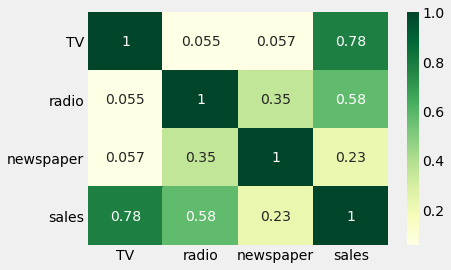

In [81]:
# Answer:
sns.heatmap(data.corr(), annot=True, cmap='YlGn')

Of course, looking at linear association doesn't show us the whole picture. We can get a more detailed look with a scatterplot matrix.

#### Use Seaborn's `.pairplot()` function to make joint scatterplots of the data.

- See if you can guess or [figure out](http://seaborn.pydata.org/generated/seaborn.pairplot.html) how `pairplot()` might work.
- `pairplot()` plots each column against each column of a DataFrame. So, at the minimum you must have to pass in the DataFrame you want to analyze!

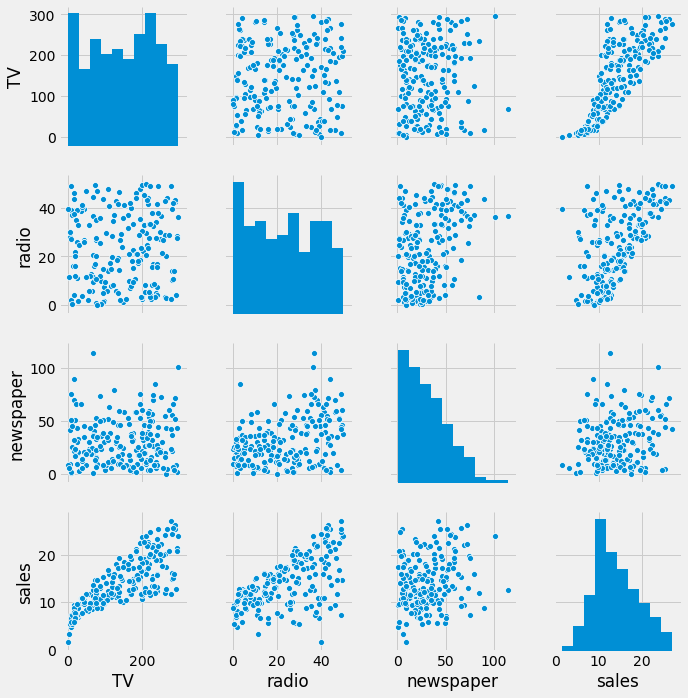

In [82]:
# Answer:
sns.pairplot(data)

In [91]:
adwords = pd.read_csv('/home/gregb/Downloads/Campaign report latest.csv', skiprows=2, skipfooter=4, thousands=",")
adwords

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,Campaign status,Campaign,Budget name,Currency code,Budget,Budget type,Status,Campaign Type,Impr.,Interactions,Interaction rate,Avg. cost,Cost,Bid strategy type
0,Removed,DataProtector campaign,--,AUD,2.00,Daily,Removed,Search,22918,27,0.12%,1.24,33.43,Manual CPC
1,Removed,ServiceManager campaign,--,AUD,1.00,Daily,Removed,Search,5,0,0.00%,--,0.00,Manual CPC
2,Removed,Campaign #2,--,AUD,1.00,Daily,Removed,Search,0,0,--,--,0.00,Manual CPC
3,Removed,VMX,--,AUD,5.00,Daily,Removed,Search,17778,27,0.15%,4.95,133.69,Maximise clicks
4,Removed,AEED,--,AUD,0.50,Daily,Removed,Search,3195,40,1.25%,0.39,15.60,Maximise clicks
5,Removed,Backup Navigator for HP,--,AUD,10.00,Daily,Removed,Search,7513,32,0.43%,3.72,119.12,Manual CPC
6,Removed,Flowers test,--,AUD,20.00,Daily,Removed,Search,0,0,--,--,0.00,Manual CPC
7,Removed,Campaign #3,--,AUD,2.00,Daily,Removed,Search,0,0,--,--,0.00,Maximise clicks
8,Paused,VMX retarget,--,AUD,1.00,Daily,Paused,Display,0,0,--,--,0.00,Maximise clicks
9,Enabled,Generic intraoral,--,AUD,1.50,Daily,Eligible (Limited),Search,3645,12,0.33%,0.30,3.61,Maximise clicks


In [92]:
adwords.corr()

,Budget,Impr.,Interactions,Cost
Budget,1.000000,-0.139568,-0.134786,-0.019050
Impr.,-0.139568,1.000000,0.993047,0.812231
Interactions,-0.134786,0.993047,1.000000,0.751559
Cost,-0.019050,0.812231,0.751559,1.000000


In [93]:
adwords.corr('spearman')

,Budget,Impr.,Interactions,Cost
Budget,1.000000,0.011816,-0.113206,-0.010508
Impr.,0.011816,1.000000,0.894386,0.906903
Interactions,-0.113206,0.894386,1.000000,0.975610
Cost,-0.010508,0.906903,0.975610,1.000000


<a id="causation-and-correlation"></a>
## Causation and Correlation
---

**Objective**: Explain the difference between causation and correlation.

- Think of various examples of studies you’ve seen in the media related to food:
    - "[Study links coffee consumption to decreased risk of colorectal cancer](https://news.usc.edu/97761/new-study-links-coffee-consumption-to-decreased-risk-of-colorectal-cancer/)"
    - "[Coffee does not decrease risk of colorectal cancer](http://news.cancerconnect.com/coffee-does-not-decrease-risk-of-colorectal-cancer/)"

There's a whole book series based on these [Spurious Correlations](http://www.tylervigen.com/spurious-correlations).

**So, why are these spurious correlations so common?**

- Is it because of sensational headlines?
- There's a neglect of robust data analysis.
- Causal claims and associations are difficult to convey in an unambiguous way.

The food claims above are **correlated** but may or may not be **causal**.

<a id="structure-of-causal-claims"></a>
### Structure of Causal Claims

- If X happens, Y must happen.
- If Y happens, X must have happened.
  - (You need X and something else for Y to happen.)
- If X happens, Y will probably happen.
- If Y happens, X probably happened.

> **Note:** Properties from definitions are not causal. If some a shape is a triangle, it's implied that it has three sides. However, it being a triangle does not _cause_ it to have three sides.

<a id="why-do-we-care"></a>
### Why Do We Care?

- Understanding this difference is critical for executing the data science workflow, especially when identifying and acquiring data.
- We need to fully articulate our question and use the right data to answer it while also considering any **confounders**.

> **Confounders** are unobserved variables that could affect the outcome. If we neglect to include confounding variables in an analysis, we could easily produce an inaccurate model. For example, we might falsely assume that eating more ice cream cones causes us to wear fewer layers of clothing. In actuality, eating ice cream is correlated with a confounding variable — temperature! To perform an accurate analysis, we can only conclude that ice cream consumption is _correlated with_ clothing layers.

- We don’t want to overstate what our model measures.
- Be careful not to say “caused” when you really mean “measured” or “associated.”

<a id="how-do-we-determine-if-something-is-causal"></a>
### How Do We Determine if Something is Causal?

Considering causal criteria is one approach to assessing causal relationships.

However, it’s hard to define universal causal criteria.

One attempt that's commonly used in the medical field is based on work by Bradford Hill.


He developed a list of “tests” that an analysis must pass in order to indicate a causal relationship:


- Strength of association
- Consistency
- Specificity
- Temporality
- Biological gradient
- Plausibility
- Coherence
- Experiment
- Analogy


**Strength (effect size)**: A small association does not mean that there is not a causal effect, although the larger the association, the more likely the effect is to be causal.

**Consistency (reproducibility)**: Consistent findings observed by different persons in different places with different samples strengthens the likelihood of an effect.

**Specificity**: Causation is likely if there is a very specific population at a specific site and a disease with no other likely explanation. The more specific an association between a factor and an effect, the greater the probability of a causal relationship.

**Temporality**: The effect has to occur after the cause (and, if there is an expected delay between the cause and expected effect, then the effect must occur after that delay).

**Biological gradient**: Greater exposure should generally lead to greater incidence of the effect. However, in some cases, the mere presence of the factor can trigger the effect. In other cases, an inverse proportion is observed: greater exposure leads to lower incidence.

**Plausibility**: A plausible mechanism between cause and effect is helpful (but Hill noted that knowledge of the mechanism is limited by current knowledge).

**Coherence**: Coherence between epidemiological and laboratory findings increases the likelihood of an effect. However, Hill noted that "... lack of such [laboratory] evidence cannot nullify the epidemiological effect on associations."

**Experiment**: "Occasionally it is possible to appeal to experimental evidence."

**Analogy**: The effect of similar factors may be considered.

<a id="pearlean-causal-dag-model"></a>
## The Pearlean Causal Directed Acyclic Graph (DAG) Model

---
### Some Quick Background Notes:

- This model is a visual tool to help us reason about causality and association.
- It was proposed by Judea Pearl, although there are many similar models.
- We will only scratch the surface, so look into other resources if you're interested in learning more.
    - We'll cover the basic idea and most notable cases.
    - We won't talk about the formal mathematics or underlying probability, or how to use d-separation to infer causality.

<a id="what-is-a-dag"></a>
### What Is a DAG?
- DAG stands for directed acyclic graph; it's a collection of nodes connected by lines. 
- Each line has an arrow to point in a direction.
- If you follow the arrows, you reach a final node. There are no loops.

A single circle or node in a causal DAG represents an event; something that happens at one point in time.

![](./assets/images/dag1.png)

Let's pretend random variables X and Y — or two different types of events — are correlated with each other.

**What are the possible causal structures that would produce this correlation?**

- X causes Y.
- Y causes X.
- There is no actual causation.
- X or Y indirectly causes the other.
- There is a third factor that causes both.
- X and Y cause a third factor, but our data collect the third factor unevenly.

<a id="its-possible-that-x-causes-y"></a>
### X causes Y.
![](./assets/images/x-cause-y.png)

In [ ]:
# Example where X is a function of Y:
X = np.random.randn(100)
Y = 5 + 2*X + np.random.randn(100)
dag = pd.DataFrame({'X':X, 'Y':Y})

# Make a pairplot of the data -- remember that pairplot() takes in a DataFrame!

<a id="y-causes-x"></a>
### Y causes X.
![](./assets/images/y-cause-x.png)

In [ ]:
# Example where X is a function of Y:
Y = np.random.randn(100)
X = 5 + 2*Y + np.random.randn(100)
dag = pd.DataFrame({'X':X, 'Y':Y})

# Make a pairplot of the data:

<a id="the-correlation-between-x-and-y-is-not-statistically-significant"></a>
### The correlation between X and Y is not statistically significant.
![](./assets/images/xy.png)

In [ ]:
# No correlation between X and Y:
X = np.random.randn(100)
Y = 5 + np.random.randn(100)
dag = pd.DataFrame({'X':X, 'Y':Y})

# Make a pairplot of the data:

<a id="x-or-y-may-cause-one-or-the-other-indirectly-through-another-variable"></a>
### X or Y may cause one or the other indirectly through another variable.
![](./assets/images/x-c-z-y.png)

In [ ]:
# Y is a function of Z, and Z is a function of X:
X = 5 + np.random.randn(100)
Z = X + 0.1*np.random.randn(100)
Y = 3 + Z + np.random.randn(100)

dag = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})

# Make a pairplot of the data:

<a id="there-is-a-third-common-factor-that-causes-both-x-and-y"></a>
### There is a third common factor that causes both X and Y.
![](./assets/images/z-cause-xy.png)

In [ ]:
# Both X and Y are functions of Z:
Z = np.random.randn(100)

X = 5 + 2*Z + np.random.randn(100)
Y = 3 + 3*Z + np.random.randn(100)
common_cause = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})

# Make a pairplot of the data:

<a id="both-x-and-y-cause-a-third-variable-and-the-dataset-does-not-represent-that-third-variable-evenly"></a>
### X and Y cause a third factor, but our data collect the third factor unevenly.

![](./assets/images/xy-causez.png)

In [ ]:
# Z is a function of X and Y:
X = 5 + np.random.randn(100)
Y = 3 + np.random.randn(100)
Z = X + Y + 0.1*np.random.randn(100)
common_effect = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})

# Make a pairplot of the data:

Generally, recovering the causality structure from a correlation matrix is difficult or at times impossible. However, thinking through causal effects can give you a much better intuition regarding your variables and your data.

### What Is a "Confounder"?

Let’s say we performed an analysis to understand what causes lung cancer. 

We find that people who carry cigarette lighters are 2.4 times more likely to contract lung cancer than people who don’t carry lighters.

Does this mean that the lighters are causing cancer?

As we've noted before, if lighters and cancer are both caused by smoking, there will be a correlation between lighters and cancer. This isn't the only possible diagram, but it makes the most sense.
![](./assets/images/smoke-lighter-cancer.png)

If we believe the structure above, conditioning on smoking by only looking at non-smokers removes the correlation between lighters and cancer.

<a id="controlled-experiments"></a>
### Controlled Experiments

- The most foolproof way to measure an effect is to control all of the confounders and directly intervene and control our variable of interest. 
- This way we know that any correlation we find is not because of the confounders but instead because of the variable we control. 
- This also means that all the effects we see are due to the variable we control.
- However, experiments are not always possible and take longer than using observational data.

<a id="when-is-it-ok-to-rely-on-association"></a>
### When Is it OK to Rely on Association?

- **When any intervention that arises from your model affects only the outcome variable.**
    - In other words, you only need to predict Y.
    - This works because we only need to observe explanatory variables and implicitly know the confounders' effect.
    - Decision-making and intervention based on your model are hidden dangers that can shift confounders.
    - You can always retrain your model to work with a new set of confounders if they shift.

- **When correlation is causal.**
    - If you are sure there are no confounding factors or selection bias, then that association might be a causation (risky).
    - It's OK to exclude confounders that have very unlikely or small effects.
    - This is a saving grace. To create a good model, you only need variables that correlate with your outcome.
        - Those variables merely need to meaningfully correlate with your outcome.

<a id="how-does-association-relate-to-causation"></a>
### How Does Association Relate to Causation?

- Most commonly, we find an association between two variables.
    - There is an observed correlation between the variables.
    - There is an observed correlation in a subset of data.
    - We find that the descriptive statistics significantly differ in two subsets of data.

- We may not still fully understand the causal direction (e.g., does smoking cause cancer or does cancer cause smoking?).
    - A causes B, B causes A, or a third factor causes both.
        - A and B never cause each other!

- We also might not understand other factors influencing the association.

Confounding variables often hide the true association between causes and outcomes.

A directed acyclic graph (DAG) can help determine which variables are most important for your model. It helps to visually demonstrate the logic of your models.

A DAG always includes at least one exposure/predictor and one outcome.


### Code-Along: Explore the Associations in the Advertising Data

#### Visualize the relationship between the features and the response using scatterplots.

- Below, we filled in how to make a scatterplot for the columns `sales` vs `TV`. 
- Using this as an example, can you also make scatterplots for `sales` vs `radio` and `sales` vs `newspaper`?
- `axs[0]` is the first coordinate grid, `axs[1]` is the second coordinate grid, etc.

In [1]:
# Visualize the relationship between the features and the response using scatterplots:
fig, axs = plt.subplots(1, 3, sharey=True)

data.plot(kind='scatter', x='TV', y='sales', ax=axs[0], figsize=(10, 6));

NameError: name 'plt' is not defined

#### Is there a relationship between ads and sales? Which type of ads?

In [ ]:
# Answer:

#### Can we say this a causal relationship?

In [ ]:
# Answer:

#### What other questions might we want to know about this data?

In [ ]:
# Answer:

### Group Exercise: Evaluate Which Type of Ad is Associated With Higher Sales

Let's say we want to evaluate which type of ad is associated with higher sales.

1. Draw a basic DAG on your table or whiteboard.
    - Think about other variables that may predict sales.
    - Think about confounders.
    - Think about the downstream effects changing investment in advertising.
    - Be ready to share an example.

### Section Summary

1) **It's important to have deep subject area knowledge, which you will develop over time, as it will help you move through your analysis in a logical manner. Also keep in mind that you can show a strong association and still be wrong.

2) **A DAG (directed acyclic graph) can be a handy tool for thinking through the logic of your models.**

3) **There is a distinction between causation and correlation.** In our smoking example, it's relatively obvious that there's a flaw in our logic; however, this won't always be so readily apparent — especially in cutting-edge fields where there are many other unknown variables.

4) **Good data are essential.** Throughout this course we will be developing your data intuition so you can spot gaps and bias more readily. You'll also be introduced to tools that can help. However, your analysis is only as good as your understanding of the problem and the data.

<a id="sampling-bias"></a>
## Sampling Bias
---

**Sampling bias** occurs when a sample is collected in such a way that some members of the intended population are more or less likely to be included than others.

This can happen when a sample is taken non-randomly — either implicitly or explicitly.

When we have non-random sampling that results in sampling bias, it can affect the inferences or results of our analyses. We must be sure not to attribute our results to the process we observe when they could actually be because of non-random sampling.

Conceptually, this is straightforward: When we have sampling bias, we aren't measuring what we think we are measuring.

<a id="forms-of-sampling-bias"></a>
### Examples of Sampling Bias

- **Pre-screening:** Purposely restricting the sample to a specific group or region.
    - This typically happens when people try to study priority areas to save costs and assume priority areas are the same as random areas.
- **Self-selection:** When someone has the ability to non-randomly decide what is included in a sample.
    - This typically happens in surveys and polls but can also be an issue with other kinds of reporting.
- **Survivorship bias:** When we select only surviving subjects in a sample over time.
    - This might happen when we only look at existing customers and assume they have the same characteristics as new customers.

<a id="problems-from-sampling-bias"></a>
### Problems That Arise From Sampling Bias
- We could overestimate or underestimate means and sample statistics for simple characteristics.
- It's possible to have artificial correlation where there should be none.

<a id="recovering-from-sampling-bias"></a>
### Recovering From Sampling Bias
- Working out causal DAGs can help you identify when to watch out for sampling bias.
- Generally, it's best to prevent sampling bias whenever possible.
- We can't really do anything if we ENTIRELY exclude an important group of data.
- However, if portions of our data are overrepresented or underrepresented, there are ways to correct that effect.
    - Typically, we explicitly model the selection process, which means we need data on factors that determine whether  or not someone participates.

<a id="stratified-random-sampling"></a>
### Stratified Random Sampling

We've discussed how it is important to obtain a random sample of our population. However, sometimes it is more effective to apply some reasoning to our sampling process. By optimizing how we choose samples, we can possibly create a more accurate model using fewer samples.

- **Stratified random sampling** ensures we capture important population characteristics in the random sample. If we know that the population is half males and half females, for example, we can make sure that our sample is half male and half female. We effectively break the population into two "strata" (groups), then randomly sample from each group to obtain our overall sample. This method is similar to taking a weighted average and depends on knowing key population statistics.
    - For example, if we are collecting survey data, we might ensure our participants are evenly split between men and women.

<a id="missing-data"></a>
## Missing Data
---

Sometimes we are unable to collect every attribute for a particular observation.

Unfortunately, this makes the observation unusable until we decide how to deal with it.

**We have to decide whether to:**
    - Drop the observation.
    - Drop the attribute.
    - Impute a value for that specific attribute and observation.

**So, how do we decide?**

<a id="types-of-missing-data"></a>
### Types of Missing Data

- **Missing completely at random (MCAR)**
    - The reason that the data are missing is completely random and introduces no sampling bias.
    - In this case, it's safe to drop or impute.
    - We can test for this by looking at other attributes for missing and non-missing groups to see if they match.

- **Missing at random (MAR)**
    - The data are missing in a way that is related to another factor.
    - This is a form of sampling bias.
    - Like other instances of sampling bias, we can fix this by modeling the selection process.
        - This is done by building a model to impute the missing value based on other variables.

- **Missing not at random (MNAR)**
    - The response is missing in a way that relates to its own value.
    - We can't test for this.
    - We also can't fix this in a reasonable way.

<a id="de-minimis"></a>
### De Minimis
- If few enough observations are missing, it's not likely to change our results to a meaningful degree.
- In these cases, we don't have to bother with trivialities and simply pick a method that works well enough.

<a id="class-imbalance"></a>
### Class Imbalance

Sometimes a sample may include an overrepresentation of one type of class. For example, airport security may have 990 X-ray scans showing the absence of a weapon. Due to natural scarcity, it may only provide 10 scans showing a weapon.

- If our goal is to create a model that indicates whether or not a weapon is present, then we are at a disadvantage. **Ignoring the class imbalance** would lead to a model that always guesses that a weapon is not present!
    - Note that most optimization procedures optimize for training data accuracy. Always guessing that a weapon is absent leads to 990/1000 correct results; an accuracy of 99 percent.

- A simple way to get around this is to **undersample** the majority class, deliberately leaving us with a balanced data set of 10 each. However, this is less than ideal, as it effectively ignores much of the available data.

- Alternatively, we could **oversample** the minority class by duplicating examples. Again, this is not ideal. Because we have very little data, this will magnify small differences that may just be errors, leading to a model that overfits.

Later in the course, we will look at additional methods for training models to work around class imbalance. For example, we may use an optimization algorithm that cares less about accuracy and more about minimizing particular types of errors.

<a id="relation-to-machine-learning"></a>
### Relation to Machine Learning

Many of the topics discussed in this lesson are used in both statistics and machine learning. However, some of the terminology differs. 

Throughout this lesson, we have discussed **variables** (typically **independent variables** and **dependent variables**). For example, we might be given the **linear estimator** $Y = mX + b$. We could say that this contains two variables ($X$ - independent and $Y$ - dependent (i.e., the prediction, as it depends on $X$)), a coefficient of $m$, and the constant of $b$.

In machine learning, we typically rewrite this as a function — $\hat{y}(x) = mx + b$ — and call it a **linear model**. The predicted value is $\hat{y}(x)$ ("prediction" is denoted by the carat), which is dependent on $x$. We might call $x$ a **feature** rather than a variable.

> **Example:** Suppose a house price $P$ is linearly dependent on its square footage $S$. So, we might predict $P = cS + b$, where $c$ and $b$ are constants. Alternatively, we could write $\hat{p}(s) = cs + b$. Here, we took a complicated house and modeled it using a single feature — its square footage. Of course, we are likely missing many confounding variables/features that also affect the price! So, our model likely contains a lot of errors.

<a id="introduction-to-hypothesis-testing"></a>
## Introduction to Hypothesis Testing
---

**Objective**: Test a hypothesis within a sample case study.

You'll remember that we've worked previously on descriptive statistics such as mean and variance. How would we tell if there is a difference between our groups? How would we know if this difference was real or if our finding is simply the result of chance?

For example, if we are working on sales data, how would we know if there was a difference between the buying patterns of men and women at Acme, Inc.? Hypothesis testing!

> **Note:** In this course, hypothesis testing is primarily used to assess foundational models such as linear and logistic regression.

### Hypothesis Testing Steps

Generally speaking, we start with a **null hypothesis** and an **alternative hypothesis**, which is the opposite of the null. Then, you check whether the data support rejecting your null hypothesis or fail to reject the null hypothesis.

For example:

    Null hypothesis: There is no relationship between gender and sales.
    Alternative hypothesis: There is a relationship between gender and sales.

Note that "failing to reject" the null hypothesis is not the same as "accepting" it. Your alternative hypothesis may indeed be true, but you don't necessarily have enough data to show that yet.

This distinction is important for helping you avoid overstating your findings. You should only state what your data and analysis can truly represent.

<a id="validate-your-findings"></a>
### Validate Your Findings

#### How Do We Tell if the Association We Observed is Statistically Significant?

Statistical significance is the likelihood that a result or relationship is caused by something other than mere random chance. Statistical hypothesis testing is traditionally employed to determine whether or not a result is statistically significant.

We might ask: **How likely is the effect observed to be true, assuming the null hypothesis is true?** If the probability of our observation occurring by chance is less than 5 percent (supposing the null hypothesis), then we reject the null hypothesis. Note that the 5 percent value is in many ways arbitrary — many statisticians require even higher confidence levels.

The probability of our observations occurring by chance, given the null hypothesis, is the **pvalue** ($p$).

---

**Example:** Suppose you flip a coin three times and get three heads in a row. These three flips are our observations.

+ We want to know whether or not the coin is fair. So, we select the **null hypothesis: The coin is fair.**
+ Now, let's suppose the null hypothesis is true. Three heads in a row occurs with a chance of $1/2^3 \approx 12.5\%$.
+ Because there is a reasonable ($> 5\%$) chance of three heads occurring naturally, we do not reject the null hypothesis.
+ So, **we conclude** that we do not have enough data to tell whether or not the coin is fair ($p = 0.125$).

---

In other words, we say that something is NOT statistically significant if there is a less than 5 percent chance that our finding was caused by chance alone (assuming the null hypothesis is true).

<a id="confidence-intervals"></a>
### Confidence Intervals

A closely related concept is **confidence intervals**. A 95 percent confidence interval can be interpreted like so: under infinite sampling of the population, we would expect that the true value of the parameter we are estimating to fall within that range 95% of the time.

Keep in mind that we only have a **single sample of data** and not the **entire population of the data**. The "true" effect/difference is either within this interval or it is not. We have no firm knowledge, however, that our single estimate of the "true" effect/difference is close or not to the "truth". The confidence interval around our estimate tells us, with a given sample size and level of confidence, the range in which future estimates are likely to fall.

Note that using 95 percent confidence intervals is just a convention. You can create 90 percent confidence intervals (which will be more liberal), 99 percent confidence intervals (which will be more conservative), or whatever intervals you prefer.


<a id="error-types"></a>
### Error Types

Statisticians often classify errors not just as errors but as one of two specific types of errors — type I and type II.

+ **Type I errors** are false positives.
    - Machine learning: Our model falsely predicts "positive." (The prediction is incorrect.)
    - Statistics: Incorrect rejection of a true null hypothesis.


+ **Type II errors** are false negatives.
    - Machine learning: Our model falsely predicts "negative." (The prediction is incorrect.)
    - Statistics: Incorrectly retaining a false null hypothesis.


Understanding these errors can be especially beneficial when designing models. For example, we might decide that type I errors are OK but type II errors are not. We can then optimize our model appropriately.

> **Example:** Suppose we make a model for airline security in which we predict whether or not a weapon is present ("positive"). In this case, we would much rather have type I errors (falsely predict a weapon) than type II errors (falsely predict no weapon).

> **Example:** Suppose we make a model for the criminal justice system in which we whether or not a defendant is guilty ("positive"). In this case, we would much rather have type II errors (falsely predict innocent) than type I errors (falsely predict guilty).

Can you phrase these examples in terms of null hypotheses?

## Class Challenge: A/B Testing Hypothesis Tests

<a id="scenario"></a>

---

### Scenario

You are a data science team working for a web-based company and you are planning to roll out a new website design. One of two competing designs were presented to random samples of users, and their ultimate purchase total was recorded (if any).

Your task is to determine which of the two designs yields higher total purchases and if the result is statistically significant.

In [99]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

%matplotlib inline
np.random.seed(42)

In [100]:
# Generate some data and randomize.

# Some people bought nothing, the others bought 
# with some distribution.
data1 = [0] * 50
data1.extend(np.random.normal(14, 4, 150))
np.random.shuffle(data1)

# The second design hooked less people, 
# but those that were hooked bought more stuff.
data2 = [0] * 100
data2.extend(np.random.normal(20, 5, 100))
np.random.shuffle(data2)

# Make a DataFrame.
df = pd.DataFrame()
df["A"] = data1
df["B"] = data2

df.head() 

,A,B
0,14.685473,25.666710
1,20.152146,0.000000
2,14.274252,18.370134
3,12.122102,26.632519
4,18.228489,25.862179


#### Plot out the distributions of group A and group B.

- Plot a histogram of ONLY the group A column, and ONLY the group B column.

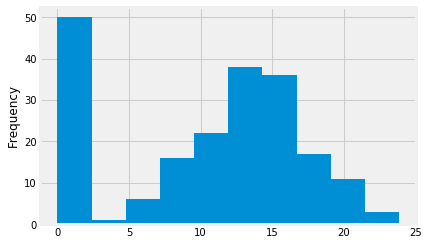

In [102]:
# Answer:
df.A.plot.hist()

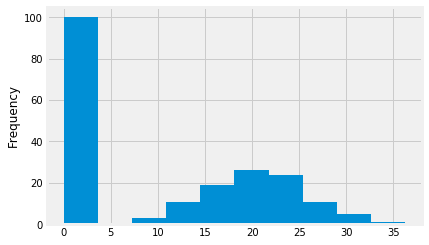

In [103]:
# Answer:
df.B.plot.hist()

#### Make a box plot of the two groups:

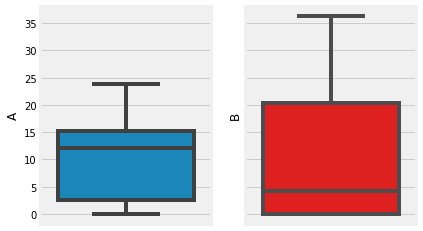

In [121]:
# Plot the boxplox
(fig, ax) = plt.subplots(1,2, sharey=True)
sns.boxplot(df.A, ax=ax[0], orient='vertical')
sns.boxplot(df.B, ax=ax[1], color='red', orient='vertical')

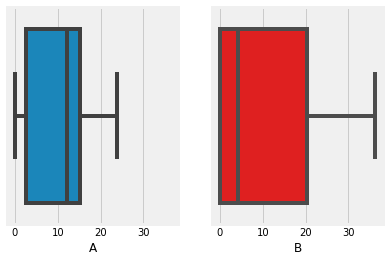

In [122]:
# Plot the boxplox
(fig, ax) = plt.subplots(1,2, sharex=True)
sns.boxplot(df.A, ax=ax[0])
sns.boxplot(df.B, ax=ax[1], color='red')

#### Are our data sets (approximately) normal? Use what we learned in the previous lesson to decide:

In [ ]:
# Plot the distributions for group A and B. Are they approximately normal?

In [124]:
!pip install fitter

In [123]:
import fitter

In [128]:
f = fitter.Fitter(df.A)
f.fit()

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=1.1919024620763778)
Fitted anglit distribution with error=1.1772521518238153)
Fitted arcsine distribution with error=0.9705893108472007)
Fitted argus distribution with error=1.1742092108515831)
Fitted beta distribution with error=1.0863289875772064)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=1.1943439931186934)
Fitted bradford distribution with error=1.154008578212972)
Fitted burr distribution with error=1.0046413114359054)
Fitted burr12 distribution with error=0.9436645537232765)
Fitted cauchy distribution with error=1.1628307997648135)
Fitted chi distribution with error=1.184543851654996)
Fitted chi2 distribution with error=1.05461132973601)
Fitted cosine distribution with error=1.1820016643281286)
Fitted crystalball distribution with error=1.1835004043760755)
Fitted dgamma distribution with error=1.184261173471632)
Fitted dweibull distribution with error=1.1309457948894126)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 23.1.
  RuntimeWarning)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 20.9.
  RuntimeWarning)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 21.266666666666673.
  RuntimeWarning)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 21.81666666666667.
  RuntimeWarning)
/home/gregb/experiments-h

Fitted erlang distribution with error=1.1869352603172945)
Fitted expon distribution with error=1.17380025860633)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1410: RuntimeWarning: overflow encountered in multiply
  return 0.5 * invK * expval * sc.erfc(-(x - invK) / np.sqrt(2))


Fitted exponnorm distribution with error=inf)
Fitted exponpow distribution with error=0.4962723654441908)
Fitted exponweib distribution with error=0.5665971125712892)
Fitted f distribution with error=0.7233218139046284)
Fitted fatiguelife distribution with error=1.0007531692899887)
Fitted fisk distribution with error=0.5380545816852014)
Fitted foldcauchy distribution with error=1.200537921471278)
Fitted foldnorm distribution with error=1.2421480360943977)
Fitted frechet_l distribution with error=2.115274362454483)
Fitted frechet_r distribution with error=0.7647235537574614)
Fitted gamma distribution with error=1.187364355148594)
Fitted gausshyper distribution with error=1.035731212417855)
Fitted genexpon distribution with error=1.1849776528812954)
Fitted genextreme distribution with error=1.1689500376382562)
Fitted gengamma distribution with error=1.1918780417826318)
Fitted genhalflogistic distribution with error=1.1573740787844404)
Fitted genlogistic distribution with error=1.15326261

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=0.8569142395480429)
Fitted gilbrat distribution with error=1.2152503720215595)
Fitted gompertz distribution with error=1.3599302640584214)
Fitted gumbel_l distribution with error=1.1598577192183908)
Fitted gumbel_r distribution with error=1.2078887594042096)
Fitted halfcauchy distribution with error=1.1959880320883125)
Fitted halfgennorm distribution with error=1.118671315075892)
Fitted halflogistic distribution with error=1.1840903979482378)
Fitted halfnorm distribution with error=1.2011853236059562)
Fitted hypsecant distribution with error=1.1766494359988684)
Fitted invgamma distribution with error=1.1904785946686651)
Fitted invgauss distribution with error=1.1959977151579873)
Fitted invweibull distribution with error=1.0909700007031216)
Fitted johnsonsb distribution with error=1.3184606945991526)
Fitted johnsonsu distribution with error=1.1622068610648781)
Fitted kappa3 distribution with error=0.8064977989664422)
Fitted kappa4 distribution wi

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=nan)
Fitted kstwobign distribution with error=1.208681309665958)
Fitted laplace distribution with error=1.1675880437557038)
Fitted levy distribution with error=1.1066437996008942)
Fitted levy_l distribution with error=1.2405528942235406)
SKIPPED levy_stable distribution (taking more than 30 seconds)
Fitted loggamma distribution with error=1.161077458704345)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


Fitted logistic distribution with error=1.1810635999125785)
Fitted loglaplace distribution with error=0.7685853278432889)
Fitted lognorm distribution with error=0.7700575652598673)
Fitted lomax distribution with error=1.1736879712226342)
Fitted maxwell distribution with error=1.195478814712414)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1618: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted mielke distribution with error=0.6186830703654469)
Fitted moyal distribution with error=1.2159793379674209)
Fitted nakagami distribution with error=0.9712730404490535)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


Fitted ncf distribution with error=1.0789305442443882)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5284: RuntimeWarning: overflow encountered in exp
  Px = np.exp(trm1)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5290: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5287: RuntimeWarning: overflow encountered in multiply
  trm1 /= np.asarray(fac1*sc.gamma((n+1)/2))
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5289: RuntimeWarning: overflow encountered in multiply
  trm2 /= np.asarray(np.sqrt(fac1)*sc.gamma(n/2+1))


Fitted nct distribution with error=1.1838636027477312)
Fitted ncx2 distribution with error=0.934419026691043)
Fitted norm distribution with error=1.1835004040876207)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:3358: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:3358: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)


Fitted norminvgauss distribution with error=1.1834528888473603)
Fitted pareto distribution with error=1.0144536132998303)
Fitted pearson3 distribution with error=1.1628228770725157)
Fitted powerlaw distribution with error=1.1742335562107074)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: divide by zero encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: invalid value encountered in multiply
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: overflow encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))


Fitted powerlognorm distribution with error=1.224619506715153)
Fitted powernorm distribution with error=1.163277685499255)
Fitted rayleigh distribution with error=1.1983146356855559)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5773: RuntimeWarning: divide by zero encountered in power
  return np.power((1.0 - x**2), c / 2.0 - 1) / sc.beta(0.5, c / 2.0)


Fitted rdist distribution with error=1.2719755912660864)
Fitted recipinvgauss distribution with error=1.1902235005312745)
Fitted reciprocal distribution with error=1.346306374663288)
Fitted rice distribution with error=1.187944963833631)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=1.1730068493281023)
Fitted skewnorm distribution with error=1.1583273395467777)
Fitted t distribution with error=1.183501298085274)
Fitted trapz distribution with error=1.2369939772317986)
Fitted triang distribution with error=1.157070693532327)
Fitted truncexpon distribution with error=1.1603907542070675)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:6348: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:6348: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


Fitted truncnorm distribution with error=1.346306374663288)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:6408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


Fitted tukeylambda distribution with error=1.1597240994052442)
Fitted uniform distribution with error=1.1705483623051571)
Fitted vonmises distribution with error=3.1618814402541273e+59)
Fitted vonmises_line distribution with error=1.1588401778560795)
Fitted wald distribution with error=1.2167531139585814)
Fitted weibull_max distribution with error=2.115274362454483)
Fitted weibull_min distribution with error=0.7647235537574614)
Fitted wrapcauchy distribution with error=nan)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


,sumsquare_error
exponpow,0.496272
fisk,0.538055
exponweib,0.566597
mielke,0.618683
f,0.723322


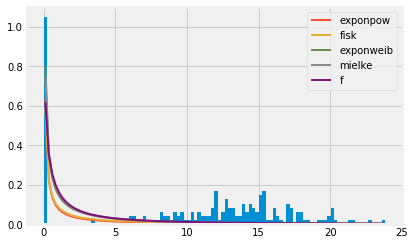

In [129]:
f.summary()

In [130]:
f2 = fitter.Fitter(df.A[df.A > 0])
f2.fit()

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=0.1565180903522021)
Fitted anglit distribution with error=0.18247193660346092)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted arcsine distribution with error=0.4077458617981385)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:7115: RuntimeWarning: divide by zero encountered in double_scalars
  return chi**3 / (_norm_pdf_C * _argus_phi(chi)) * x * np.sqrt(y) * np.exp(-chi**2 * y / 2)


Fitted argus distribution with error=0.23422020860322465)
Fitted beta distribution with error=0.1543676735471789)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=0.16168268003433134)
Fitted bradford distribution with error=0.2997186770057759)
Fitted burr distribution with error=0.1515514784848478)
Fitted burr12 distribution with error=0.15357189570122984)
Fitted cauchy distribution with error=0.17172985403515098)
Fitted chi distribution with error=0.1540113818179381)
Fitted chi2 distribution with error=0.15482453350842612)
Fitted cosine distribution with error=0.16178973961753151)
Fitted crystalball distribution with error=0.15348815068571803)
Fitted dgamma distribution with error=0.14569190175995034)
Fitted dweibull distribution with error=0.14688180693590955)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1885.8000000000002.
  RuntimeWarning)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1706.1999999999998.
  RuntimeWarning)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1736.1333333333332.
  RuntimeWarning)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1781.0333333333333.
  RuntimeWarni

Fitted erlang distribution with error=0.15364412205336941)
Fitted expon distribution with error=0.37850798117552975)
Fitted exponnorm distribution with error=0.15349941528414243)
Fitted exponpow distribution with error=0.1649466452434547)
Fitted exponweib distribution with error=0.15364164175327974)
Fitted f distribution with error=0.1536624542204921)
Fitted fatiguelife distribution with error=0.15371854688052305)
Fitted fisk distribution with error=0.15284668402319823)
Fitted foldcauchy distribution with error=0.16645367983733894)
Fitted foldnorm distribution with error=0.1534760201065148)
Fitted frechet_l distribution with error=1.5389483135663793)
Fitted frechet_r distribution with error=1.2897777615643862)
Fitted gamma distribution with error=0.15364368456692937)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted gausshyper distribution with error=0.15621439036717616)
Fitted genexpon distribution with error=0.21166898618871313)
Fitted genextreme distribution with error=0.1552755876183601)
Fitted gengamma distribution with error=0.15348967505088384)
Fitted genhalflogistic distribution with error=0.2294090796324416)
Fitted genlogistic distribution with error=0.15325912827131635)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted gennorm distribution with error=0.15346610055032817)
Fitted genpareto distribution with error=0.2752547475654916)
Fitted gilbrat distribution with error=0.3097805044294913)
Fitted gompertz distribution with error=0.1870660749401198)
Fitted gumbel_l distribution with error=0.17409667287214403)
Fitted gumbel_r distribution with error=0.17481721681866905)
Fitted halfcauchy distribution with error=0.35214649707429907)
Fitted halfgennorm distribution with error=0.5163427073722109)
Fitted halflogistic distribution with error=0.3235244204929119)
Fitted halfnorm distribution with error=0.3137363376407192)
Fitted hypsecant distribution with error=0.1540148551797466)
Fitted invgamma distribution with error=0.15583169892910112)
Fitted invgauss distribution with error=0.15867319759815438)
Fitted invweibull distribution with error=0.1749692806531796)
Fitted johnsonsb distribution with error=0.15366497751954789)
Fitted johnsonsu distribution with error=0.15363936703208297)
Fitted kappa3 distr

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=nan)
Fitted kstwobign distribution with error=0.1832841407471245)
Fitted laplace distribution with error=0.17056386904947135)
Fitted levy distribution with error=0.3680544173525821)
Fitted levy_l distribution with error=0.37180587485340305)
SKIPPED levy_stable distribution (taking more than 30 seconds)
Fitted loggamma distribution with error=0.15344640507134286)
Fitted logistic distribution with error=0.15273150296305202)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


Fitted loglaplace distribution with error=0.16612306702670132)
Fitted lognorm distribution with error=0.1536604143675715)
Fitted lomax distribution with error=0.38254422064302834)
Fitted maxwell distribution with error=0.17033679632778545)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1618: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Fitted mielke distribution with error=0.15155613592886893)
Fitted moyal distribution with error=0.19123990403833918)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5014: RuntimeWarning: divide by zero encountered in power
  return 2*nu**nu/sc.gamma(nu)*(x**(2*nu-1.0))*np.exp(-nu*x*x)


Fitted nakagami distribution with error=1.1905115084049158)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


Fitted ncf distribution with error=0.1659089222190303)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5284: RuntimeWarning: overflow encountered in exp
  Px = np.exp(trm1)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5290: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5287: RuntimeWarning: overflow encountered in multiply
  trm1 /= np.asarray(fac1*sc.gamma((n+1)/2))
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5289: RuntimeWarning: overflow encountered in multiply
  trm2 /= np.asarray(np.sqrt(fac1)*sc.gamma(n/2+1))


Fitted nct distribution with error=0.15353302851074896)
Fitted ncx2 distribution with error=0.15506793574808334)
Fitted norm distribution with error=0.15348815086125675)
Fitted norminvgauss distribution with error=0.15357436987856274)
Fitted pareto distribution with error=0.5897575008817981)
Fitted pearson3 distribution with error=0.1536571823714958)
Fitted powerlaw distribution with error=0.27511945183054576)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: divide by zero encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: invalid value encountered in multiply
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: overflow encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))


Fitted powerlognorm distribution with error=0.15369107614076907)
Fitted powernorm distribution with error=0.1537741096667998)
Fitted rayleigh distribution with error=0.2006654017050392)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:5773: RuntimeWarning: divide by zero encountered in power
  return np.power((1.0 - x**2), c / 2.0 - 1) / sc.beta(0.5, c / 2.0)


Fitted rdist distribution with error=0.493828312265253)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
Fitted reciprocal distribution with error=0.522511355897229)
Fitted rice distribution with error=0.15380231540487285)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=0.21860825414194196)
Fitted skewnorm distribution with error=0.1535828362587196)
Fitted t distribution with error=0.1534880138760543)
Fitted trapz distribution with error=0.3269265729473685)
Fitted triang distribution with error=0.16434603853302532)
Fitted truncexpon distribution with error=0.29627737876927324)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:6348: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:6348: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


Fitted truncnorm distribution with error=0.522511355897229)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:6408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


Fitted tukeylambda distribution with error=0.25459884302305885)
Fitted uniform distribution with error=0.2806079503892526)
Fitted vonmises distribution with error=1.3588554947040076e+57)
Fitted vonmises_line distribution with error=0.15261923549300435)
Fitted wald distribution with error=0.29215392091572606)
Fitted weibull_max distribution with error=1.5389483135663793)
Fitted weibull_min distribution with error=1.2897777615643862)
Fitted wrapcauchy distribution with error=nan)


/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


,sumsquare_error
dgamma,0.145692
dweibull,0.146882
burr,0.151551
mielke,0.151556
vonmises_line,0.152619


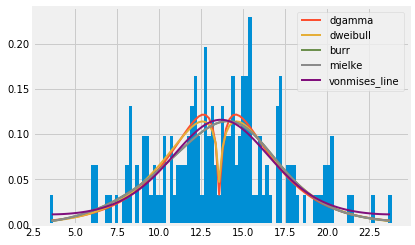

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


In [131]:
f2.summary()

The non-zero parts of df.A and df.B are pretty close to normal, so we can do a student t-test.

In [134]:
import scipy
import scipy.stats

In [136]:
scipy.stats.ttest_ind(df.A[df.A > 0], df.B[df.B > 0])

Ttest_indResult(statistic=-11.808215410386353, pvalue=7.918638190730728e-26)

In [137]:
scipy.stats.ttest_ind(df.A[df.A > 0], df.A[df.A > 0])

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [139]:
scipy.stats.mannwhitneyu(df.A[df.A > 0], df.B[df.B > 0])

MannwhitneyuResult(statistic=2240.0, pvalue=3.0080291805238774e-21)

In [140]:
scipy.stats.mannwhitneyu(df.A, df.B)

MannwhitneyuResult(statistic=19740.0, pvalue=0.40880656458636355)

/home/gregb/experiments-hypothesis-tests/.venv/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:3858: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


<a id="statistical-tests"></a>
### Statistical Tests

There are a few good statistical tests for A/B testing:
* [ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance)
* [Welch's t-test](https://en.wikipedia.org/wiki/Welch's_t-test)
* [Mann-Whitney test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

**Each test makes various assumptions:**
* ANOVA assumes the residuals are normally distributed and data have equal variances.
* The Welch t-test assumes normal distributions but not necessarily equal variances and more effectively accounts for small sample sizes.
* The Mann-Whitney test assumes nothing about the distributions but requires at least 20 data points in each set, producing a weaker p value.

Typically you need to choose the most appropriate test. Tests that make more assumptions are more discriminating (producing stronger p values) but can be misleading with data sets that don't satisfy the assumptions.

#### Which test is most appropriate for our data?

In [ ]:
# Answer:

In statistics, **one-way analysis of variance** (abbreviated one-way **ANOVA**) is a technique used to compare the means of three or more samples (using the **F distribution**). The **ANOVA** tests the **null hypothesis** (the default position that there is no relationship) that samples in two or more groups are drawn from populations with the same mean values. Typically, however, the **one-way ANOVA** is used to test for differences among at least three groups, as the two-group case can be covered by a **t-test**. When there are only two means to compare, the **t-test** and the **F-test** are equivalent.

> **Note:** 
   - One-way ANOVA: An ANOVA hypothesis tests the difference in population means based on one characteristic or factor.
   - Two-way ANOVA: An ANOVA hypothesis tests comparisons between populations based on multiple characteristics.

#### Use the Mann-Whitney test on our data.

- Look up the function in SciPy [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html).
- Statistic: Float the Mann-Whitney U statistic — equal to min(U for x, U for y) if alternative is equal to none (deprecated; exists for backward compatibility) — and U for Y otherwise.
- P value: Float p value assuming an asymptotic normal distribution — one sided or two sided, depending on the choice of alternative.

In [ ]:
# Answer:

The Mann–Whitney U test (also called the Mann–Whitney–Wilcoxon (MWW), Wilcoxon rank-sum test, or Wilcoxon–Mann–Whitney test) is a nonparametric test of the null hypothesis of whether it is equally likely that a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample.

Unlike the t-test, it does not require the assumption of normal distributions. It is also nearly as efficient as the t-test on normal distributions.

<a id="interpret-your-results"></a>
### Interpret Your Results
* Is there a significant difference in the mean total purchases in the two designs?
* Which design do you recommend? Why? 
* Write two sentences explaining your results and your recommendation.

In [ ]:
# Answer: